In [3]:
# Make the repo root importable so "import src...." works
import sys
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))
print("Added to sys.path:", ROOT)


Added to sys.path: /Users/toffs/ds-sprint


In [5]:
from pathlib import Path
from src.data.loaders import read_csv

base = ROOT / "data/raw/ml-latest-small"
print("Base exists:", base.exists())
if base.exists():
    print("Files in base:", sorted(p.name for p in base.iterdir())[:10])

ratings = read_csv(base / "ratings.csv")
movies  = read_csv(base / "movies.csv")

print("ratings shape:", ratings.shape)
print("movies shape:", movies.shape)
ratings.head()



Base exists: True
Files in base: ['README.txt', 'links.csv', 'movies.csv', 'ratings.csv', 'tags.csv']
ratings shape: (100836, 4)
movies shape: (9742, 3)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
# Hold out each user's last interaction as test
ratings_sorted = ratings.sort_values(['userId', 'timestamp'])
last = ratings_sorted.groupby('userId').tail(1)

# train = all interactions except each user's last one
train = ratings.merge(last[['userId','movieId','timestamp']], how='left', indicator=True)
train = train[train['_merge'] == 'left_only'].drop(columns=['_merge'])

# Truth for evaluation (set of relevant items per user)
import pandas as pd
test_truth = last.groupby('userId')['movieId'].apply(set).reset_index(name='relevant')

print("Train size:", len(train), "| Test users:", len(test_truth))
train.head()


Train size: 100226 | Test users: 610


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
import numpy as np

def apk(recommended, relevant, k=10):
    score = 0.0; hits = 0
    for i, item in enumerate(recommended[:k], start=1):
        if item in relevant:
            hits += 1
            score += hits / i
    return 0.0 if not relevant else score / min(len(relevant), k)

def mapk(recommended_lists, relevant_sets, k=10):
    return float(np.mean([apk(r, rel, k) for r, rel in zip(recommended_lists, relevant_sets)]))

def dcg_at_k(recommended, relevant, k=10):
    dcg = 0.0
    for i, item in enumerate(recommended[:k], start=1):
        if item in relevant:
            dcg += 1.0 / np.log2(i + 1)
    return dcg

def idcg_at_k(n_rel, k=10):
    n = min(n_rel, k)
    return sum(1.0 / np.log2(i + 1) for i in range(1, n + 1))

def ndcg_at_k(recommended, relevant, k=10):
    idcg = idcg_at_k(len(relevant), k)
    return 0.0 if idcg == 0 else dcg_at_k(recommended, relevant, k) / idcg
    

In [11]:
# Popularity baseline + evaluation
pop = train.groupby('movieId').size().sort_values(ascending=False).index.tolist()
user_seen = train.groupby('userId')['movieId'].apply(set).to_dict()

K = 10
recs, rels = [], []
for uid, relset in zip(test_truth['userId'], test_truth['relevant']):
    seen = user_seen.get(uid, set())
    recommended = [m for m in pop if m not in seen][:K]
    recs.append(recommended); rels.append(relset)

map10  = mapk(recs, rels, K)
ndcg10 = float(np.mean([ndcg_at_k(r, rel, K) for r, rel in zip(recs, rels)]))
print({"MAP@10": round(map10, 4), "NDCG@10": round(ndcg10, 4)})


{'MAP@10': 0.0125, 'NDCG@10': 0.0194}


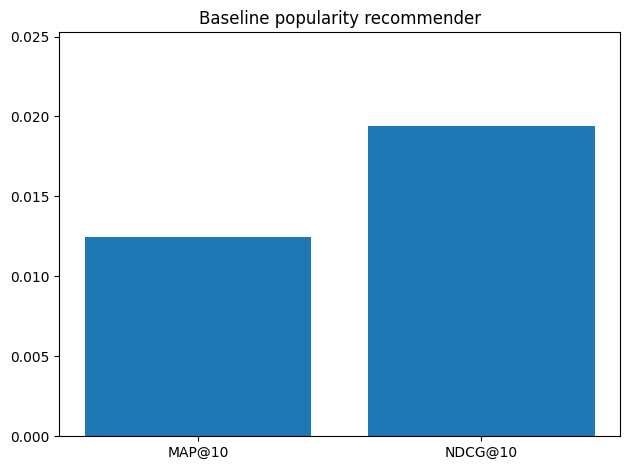

Saved plot + CSV to reports/ and projects/01_recommender/assets/


In [13]:
import os, matplotlib.pyplot as plt
import pandas as pd

# where to save
os.makedirs("projects/01_recommender/assets", exist_ok=True)  # tracked in git
os.makedirs("reports", exist_ok=True)                         # ignored by git

# bar chart (hero plot)
fig = plt.figure()
plt.bar(["MAP@10","NDCG@10"], [map10, ndcg10])
plt.title("Baseline popularity recommender")
plt.ylim(0, max(map10, ndcg10)*1.3 + 1e-6)
plt.tight_layout()

# save images
fig.savefig("reports/p1_baseline_metrics.png", dpi=150)
fig.savefig("projects/01_recommender/assets/p1_baseline_metrics.png", dpi=150)
plt.show()

# metrics table
mtx = pd.DataFrame(
    [{"metric":"MAP@10","value":float(map10)},
     {"metric":"NDCG@10","value":float(ndcg10)}]
)
mtx.to_csv("reports/p1_baseline_metrics.csv", index=False)
mtx.to_csv("projects/01_recommender/assets/p1_baseline_metrics.csv", index=False)

print("Saved plot + CSV to reports/ and projects/01_recommender/assets/")
